In [1]:
##---------------------------------------------------------------------
## Summary : Implementing the Skip-Gram model using negative sampling
## Author  : Srinivas Venkata Vemparala
## Source  : https://github.com/neubig/nn4nlp-code
##---------------------------------------------------------------------

%matplotlib inline
import numpy as np
import pandas as pd
import dynet as dy
import time 
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from sklearn.manifold import TSNE
plt.rcParams["figure.figsize"] = (14,9)

In [2]:
# lets write a method to convert the words to integers
w2i = defaultdict(lambda:len(w2i))

# lets add the words end of sentence(<s>) and unknown(<unk>) to the default dictionary
S = w2i['<s>']
UNK = w2i['<unk>']

#lets create a data structure to maintain the wordcounts
wordCounts = defaultdict(int) # here if there is no word int will give zero. 
# add word counts for S and UNK
wordCounts[0] = 0
wordCounts[1] = 0

# lets write a method to read the data from file
def readDataSet(fileName):
    retList = []
    
    with open(fileName,'r+') as file:
        for line in file:
            words = [w2i[x] for x in line.lower().strip().split(' ')]
            retList.append(words)
            # update the word counts for words in the line.
            for word in words:
                wordCounts[word] += 1
    return retList


In [3]:
# lets read the training and testing data. We are using the pen-tree-bank.
# In this the rare words are already replaced by <UNK>

train = readDataSet('../data/ptb/train.txt')
test = readDataSet('../data/ptb/valid.txt')

# lets freeze the dictionary
w2i = defaultdict(lambda:UNK, len(w2i))

# lets write a method to convert the integers back to words.
i2w = {v:k for k,v in w2i.items()}

#compute the number of words in vocabulary.
nWords = len(w2i)
print('Vocabulary size : ', nWords)


Vocabulary size :  10000


In [4]:
# now lets compute the probability for picking each word.
# we are using the same probability function used in original paper.
# prob(word) = (#times'word'occurred)^0.75/Sum((#times'anyWord'occurred)^0.75)

counts = np.array([list(x) for x in wordCounts.items()])[:,1]**(0.75)
normalizing_constant = sum(counts)

wordProb = counts/normalizing_constant
print(wordProb[0:5])
print(len(wordCounts))

[0.00000000e+00 1.63960616e-02 3.03001078e-05 3.23433942e-05
 2.38625664e-05]
10000


In [5]:
# lets declare the size of each embedding,N in N-grams and number of negative samples
nEmb = 32 # each word will have vector of length 32
N = 2     # length of window on each side (so N=2 gives a total window size of 5, as in t-2 t-1 t t+1 t+2)
K = 3     # the number of negative samples.

# Now lets define the model and trainer
model = dy.Model()
trainer = dy.SimpleSGDTrainer(model,learning_rate=0.1)

# lets add the parameters to the model
W_emb = model.add_lookup_parameters((nWords,nEmb)) # lookups for each word vector
W_sm = model.add_lookup_parameters((nWords,nEmb))         # softmax weights

In [6]:
# lets write a function to compute the loss given a sentence
def computeLoss(sent):
    # renew the computation graph
    dy.renew_cg()
    
    # get the embeddings for all words in sentence
    embList = [W_emb[x] for x in sent]
    
    # pick the random words for negative samples. For each correct one we need k wrong words with replacement
    negSamples = np.random.choice(nWords,size=2*N*K*len(sent),replace=True,p=wordProb)
    
    allLosses = []

    # iterate through each word in the sentence and compute the loss
    for i,embed in enumerate(embList):
        negWords = negSamples[i*N*K*2:(i+1)*N*K*2]  # get the neg samples for this word
        #posWords = ([sent(x) if x>=0 else S for x in range(i-N,i)]+[sent(x) if x<len(sent) else S for x in range(i+1,i+N+1)])
        posWords = ([sent[x] if x >= 0 else S for x in range(i-N,i)] +[sent[x] if x < len(sent) else S for x in range(i+1,i+N+1)])
        
        negLoss = -dy.log(dy.logistic(-dy.dot_product(embed, dy.lookup_batch(W_sm, negWords)))) # reduce the neg loglikelihood
        posLoss = -dy.log(dy.logistic(dy.dot_product(embed, dy.lookup_batch(W_sm, posWords))))  # increase the pos loglikelihood
        allLosses.append(dy.sum_batches(posLoss)+dy.sum_batches(negLoss))
    
    return dy.esum(allLosses) 

In [7]:
# lets start the training and computing the embedding
trainLosses = []
testLosses = []

print('Started training ....')

for i in range(100):
    # randomly shuffle the training examples
    random.shuffle(train)
    
    trainLoss = 0.0
    startTime = time.time()
    numOfWordsProcessed = 0
    
    for sent in train:
        loss = computeLoss(sent)
        trainLoss = trainLoss+loss.value()
        
        numOfWordsProcessed = numOfWordsProcessed + len(sent)
        
        # do backward pass to compute the gradients and update parameters
        loss.backward()
        trainer.update()
    trainLosses.append(trainLoss)
    print('Iteration ',i,' : ',' TrainingLoss : ',(trainLoss/numOfWordsProcessed),' Number of words processed : ',numOfWordsProcessed,' Time taken : ',
         (time.time()-startTime))
    
    testLoss = 0.0
    for sent in test:
        loss = computeLoss(sent)
        testLoss = testLoss+loss.value()
    testLosses.append(testLoss)
    print('Iteration ',i,' : ',' TestLoss : ',(testLoss/numOfWordsProcessed))

Started training ....
Iteration  0  :   TrainingLoss :  8.177957455764949  Number of words processed :  887521  Time taken :  75.94708561897278
Iteration  0  :   TestLoss :  0.6015356385942816
Iteration  1  :   TrainingLoss :  7.36738631643132  Number of words processed :  887521  Time taken :  75.83606195449829
Iteration  1  :   TestLoss :  0.5873026207807399
Iteration  2  :   TrainingLoss :  7.1768363454025  Number of words processed :  887521  Time taken :  76.0336742401123
Iteration  2  :   TestLoss :  0.5782291621158119
Iteration  3  :   TrainingLoss :  7.0757631103109375  Number of words processed :  887521  Time taken :  76.60730600357056
Iteration  3  :   TestLoss :  0.5775845094367796
Iteration  4  :   TrainingLoss :  7.00854528905516  Number of words processed :  887521  Time taken :  75.033935546875
Iteration  4  :   TestLoss :  0.5757728586947104
Iteration  5  :   TrainingLoss :  6.960728917615342  Number of words processed :  887521  Time taken :  72.69057941436768
Iterati

Iteration  47  :   TestLoss :  0.5822835692363053
Iteration  48  :   TrainingLoss :  6.6757191335776955  Number of words processed :  887521  Time taken :  75.63848543167114
Iteration  48  :   TestLoss :  0.5823730078863988
Iteration  49  :   TrainingLoss :  6.673329622738619  Number of words processed :  887521  Time taken :  74.55530333518982
Iteration  49  :   TestLoss :  0.583086602790724
Iteration  50  :   TrainingLoss :  6.671760599810085  Number of words processed :  887521  Time taken :  74.84442901611328
Iteration  50  :   TestLoss :  0.5837479881284059
Iteration  51  :   TrainingLoss :  6.669824511165241  Number of words processed :  887521  Time taken :  78.24670028686523
Iteration  51  :   TestLoss :  0.5829625353094644
Iteration  52  :   TrainingLoss :  6.67076547580602  Number of words processed :  887521  Time taken :  76.75038027763367
Iteration  52  :   TestLoss :  0.583197609098231
Iteration  53  :   TrainingLoss :  6.667364180186821  Number of words processed :  8875

Iteration  95  :   TestLoss :  inf
Iteration  96  :   TrainingLoss :  6.649468785107301  Number of words processed :  887521  Time taken :  79.00150346755981
Iteration  96  :   TestLoss :  inf
Iteration  97  :   TrainingLoss :  6.649885078739986  Number of words processed :  887521  Time taken :  75.9410924911499
Iteration  97  :   TestLoss :  inf
Iteration  98  :   TrainingLoss :  6.648717508403966  Number of words processed :  887521  Time taken :  77.65227508544922
Iteration  98  :   TestLoss :  inf
Iteration  99  :   TrainingLoss :  6.648751173824793  Number of words processed :  887521  Time taken :  79.93466758728027
Iteration  99  :   TestLoss :  inf


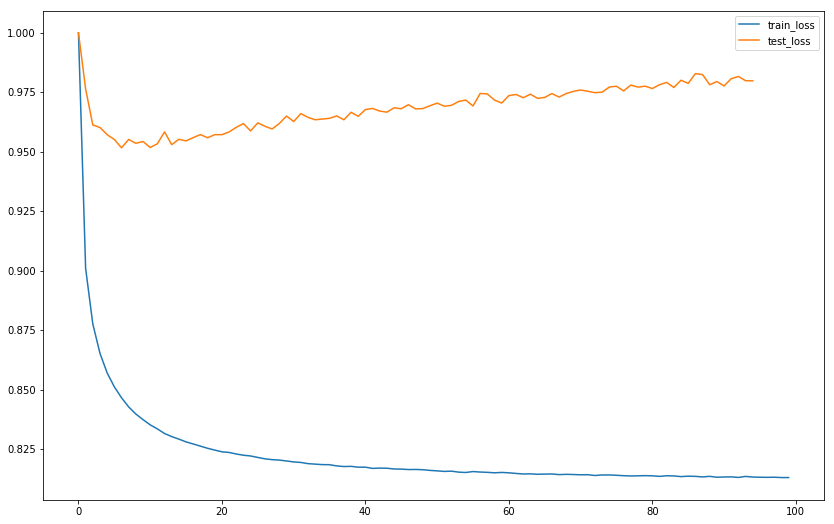

In [8]:
# normalize the training loss and test loss by dividing with initial element
trainLoss0 = trainLosses[0]
trainLosses = [(x/trainLoss0) for x in trainLosses]
    
testLoss0 = testLosses[0]
testLosses = [(x/testLoss0) for x in testLosses]
    
train_loss, = plt.plot(trainLosses,label='train_loss')
test_loss, = plt.plot(testLosses,label='test_loss')
plt.legend(handles=[train_loss,test_loss])
plt.show()

In [13]:
# lets write the input and output embeddings to file
inputEmbeddings = 'inputEmbeddingsSkipGram_negSamples.txt'
outputEmbeddings = 'outputEmbeddingsSkipGram_negSamples.txt'
labels = 'labelsSkipGram_negSamples.txt'

with open(inputEmbeddings,'w') as f:
    embeddings = W_emb.as_array()
    for i in range(nWords):
        f.write('\t'.join(map(str,embeddings[i])) + '\n')

with open(outputEmbeddings,'w') as f:
    embeddings = W_sm.as_array()
    for i in range(nWords):
        f.write('\t'.join(map(str,embeddings[i])) + '\n')
        
with open(labels,'w') as f:
    for i in range(nWords):
        f.write(i2w[i] + '\n')   

In [14]:
# read the data from the file
dfEmbeddings = pd.read_csv('inputEmbeddingsSkipGram_negSamples.txt',header=None,sep='\t')

# convert the data frame to matrix
embeddings = dfEmbeddings.as_matrix()
X_embedded = TSNE(n_components=2).fit_transform(embeddings[:150])

# read the labels
dfLabels = pd.read_csv('labelsSkipGram_negSamples.txt',header=None,sep='\n')
labels = dfLabels[0].as_matrix()


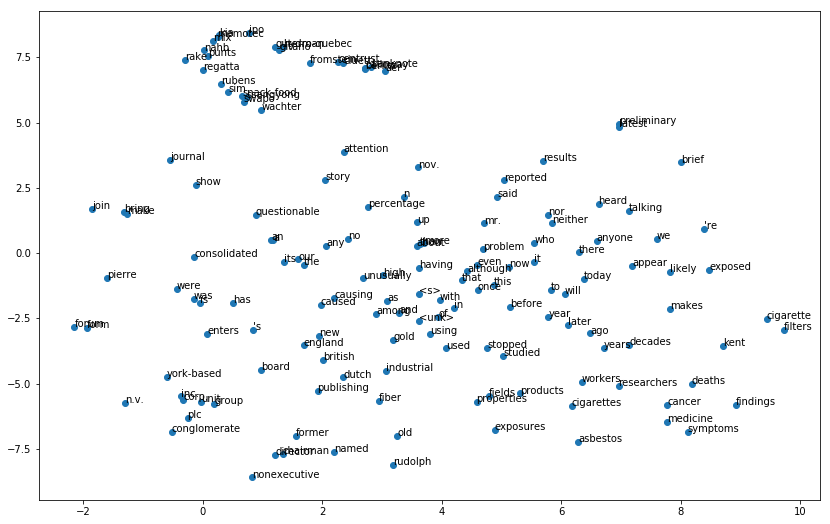

In [15]:
x = X_embedded[:,0]
y = X_embedded[:,1]
z = labels[:150]

# lets plot the data
fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(z):
    ax.annotate(txt, (x[i],y[i]))